In [1]:
#!pip install hdbscan
#!pip install yellowbrick
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.cluster import KMeans
import warnings
import statistics
from sklearn.cluster import HDBSCAN

In [2]:
file = r"C:/Users/Sudeshna Kundu/Desktop/ISB-AMPBA/Course 2/ML Unsupervised/Champo Carpets V1.csv"
data = pd.read_csv(file)
data.head(3)

,OrderiD,Item_Id,CustomerCode,CountryName,customer_country,QtyRequired,TotalArea,Amount,ITEM_NAME,QualityName,DesignName,ColorName,ShapeName
0,1,5,H-1,USA,H-1USA,6,128.25,769.5,HAND TUFTED,TUFTED 30C HARD TWIST,OLD LONDON [3715],GREEN/IVORY,REC
1,1,26,H-1,USA,H-1USA,6,117.00,702.0,HAND TUFTED,TUFTED 60C,DUDLEY [9012],BEIGE,REC
2,1,17,H-1,USA,H-1USA,7,88.00,616.0,HAND TUFTED,TUFTED 60C,WEMBLY [CC-206],BEIGE/SAGE,REC


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13135 entries, 0 to 13134
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   OrderiD           13135 non-null  int64  
 1   Item_Id           13135 non-null  int64  
 2   CustomerCode      13135 non-null  object 
 3   CountryName       13135 non-null  object 
 4   customer_country  13135 non-null  object 
 5   QtyRequired       13135 non-null  int64  
 6   TotalArea         13135 non-null  float64
 7   Amount            13135 non-null  float64
 8   ITEM_NAME         13135 non-null  object 
 9   QualityName       13135 non-null  object 
 10  DesignName        13135 non-null  object 
 11  ColorName         13135 non-null  object 
 12  ShapeName         13135 non-null  object 
dtypes: float64(2), int64(3), object(8)
memory usage: 1.3+ MB


In [4]:
print("\nSummary Statistics - Customer Data:")
data.describe()


Summary Statistics - Customer Data:


,OrderiD,Item_Id,QtyRequired,TotalArea,Amount
count,13135.000000,13135.000000,13135.000000,13135.000000,13135.000000
mean,3075.336962,14528.683746,44.460601,44.731370,2392.040164
std,2107.731646,13183.139544,228.749535,50.099597,16832.091080
min,1.000000,1.000000,1.000000,0.040000,0.000000
25%,1219.500000,3023.000000,3.000000,5.800000,163.200000
50%,2934.000000,8631.000000,8.000000,24.000000,590.625000
75%,4630.000000,26713.000000,20.000000,80.000000,1540.000000
max,7548.000000,46701.000000,6400.000000,1024.000000,599719.680000


In [5]:
data = data[~data['ITEM_NAME'].str.contains('-')]  
data = data[data['Amount']!=0.00]
print("length of data",data.shape[0])

length of data 12577


In [6]:
print("Number of Unique Items",len(data.Item_Id.unique()))

Number of Unique Items 5737


### Feature Creation

In [7]:
data['Amt_per_Area'] = data['Amount']/data['TotalArea']  # creating a new column to determine Cost Amt per Area
data['Amt_per_Qnty'] = data['Amount']/data['QtyRequired']  # creating a new column to determine Cost Amt per Area

In [8]:
df_item = data.groupby(['Item_Id']).agg({'Amount':'sum','QtyRequired':'sum',
                                           'OrderiD':'count','TotalArea':'sum'}).reset_index()
df_item.rename(columns = {'QtyRequired':'Total Quantity', 'OrderiD':'Orders','Amount':'Total Revenue'}, inplace = True) 
df_item['Amount'] = round(df_item['Total Revenue'],2)
df_item['Avg Qnty per Order'] = round(df_item['Total Quantity']/df_item['Orders'],1)
df_item['Average Size']= round(df_item['TotalArea']/df_item['Total Quantity'],1)

df_item['Avg Amt_per_Area'] = round(df_item['Total Revenue']/df_item['TotalArea'],1)
df_item['TotalArea'] = round(df_item['TotalArea'],1)
df_item.head()

,Item_Id,Total Revenue,Total Quantity,Orders,TotalArea,Amount,Avg Qnty per Order,Average Size,Avg Amt_per_Area
0,1,12.00,2,1,6.0,12.00,2.0,3.0,2.0
1,2,18.00,2,1,9.0,18.00,2.0,4.5,2.0
2,3,378.00,7,2,108.0,378.00,3.5,15.4,3.5
3,4,641.25,9,2,142.5,641.25,4.5,15.8,4.5
4,5,2821.50,22,2,256.5,2821.50,11.0,11.7,11.0


## Clustering

#### Scaling or Normalising the data

In [9]:
df_scaled = df_item
num_cols = ['Avg Qnty per Order', 'Avg Amt_per_Area']
scaler_ss = MinMaxScaler()
#for loop
for col in num_cols:
    df_scaled[col] = scaler_ss.fit_transform(df_scaled[[col]])
print("Scaled or Normalized data\n")
df_scaled.head()

Scaled or Normalized data



,Item_Id,Total Revenue,Total Quantity,Orders,TotalArea,Amount,Avg Qnty per Order,Average Size,Avg Amt_per_Area
0,1,12.00,2,1,6.0,12.00,0.000156,3.0,0.000106
1,2,18.00,2,1,9.0,18.00,0.000156,4.5,0.000106
2,3,378.00,7,2,108.0,378.00,0.000391,15.4,0.000194
3,4,641.25,9,2,142.5,641.25,0.000547,15.8,0.000253
4,5,2821.50,22,2,256.5,2821.50,0.001563,11.7,0.000636


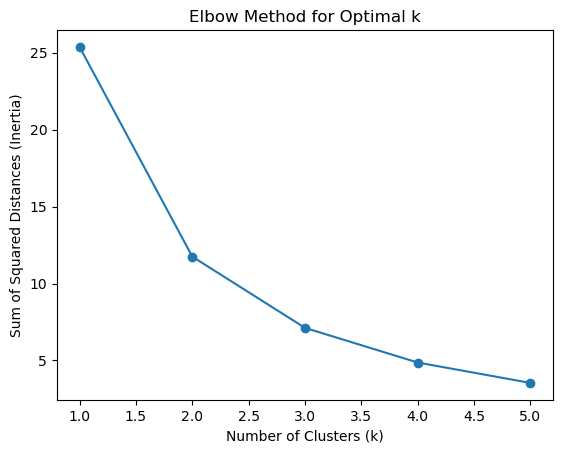

In [10]:
warnings.filterwarnings('ignore')
k_values = range(1, 6)
inertia_values = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_scaled[['Avg Qnty per Order', 'Avg Amt_per_Area']])
    inertia_values.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(k_values, inertia_values, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Distances (Inertia)')

# Show the plot
plt.show()

### Cluster Quality Evaluation

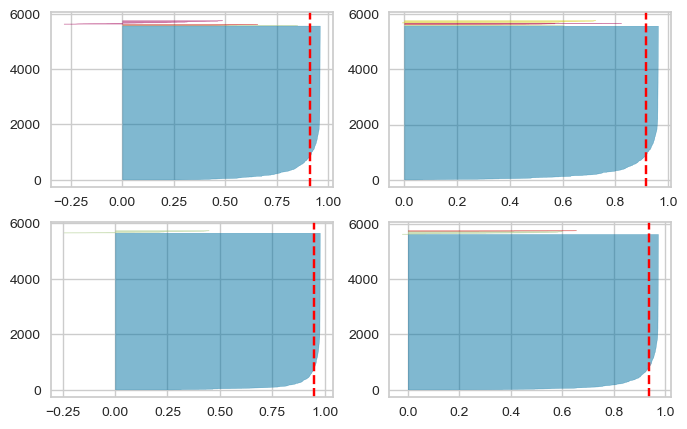

In [11]:
from yellowbrick.cluster import SilhouetteVisualizer

fig, ax = plt.subplots(2, 2, figsize=(8,5))
num_clusters = [2,3,4,5]
for i, k in enumerate(num_clusters):
    km = KMeans(n_clusters=k, 
                random_state=42)
    q, mod = divmod(i, 2)
    visualizer = SilhouetteVisualizer(km, 
                                      colors='yellowbrick', 
                                      ax=ax[q-1][mod])
    visualizer.fit(df_scaled[['Avg Qnty per Order', 'Avg Amt_per_Area']]) 

### K-means Clustering

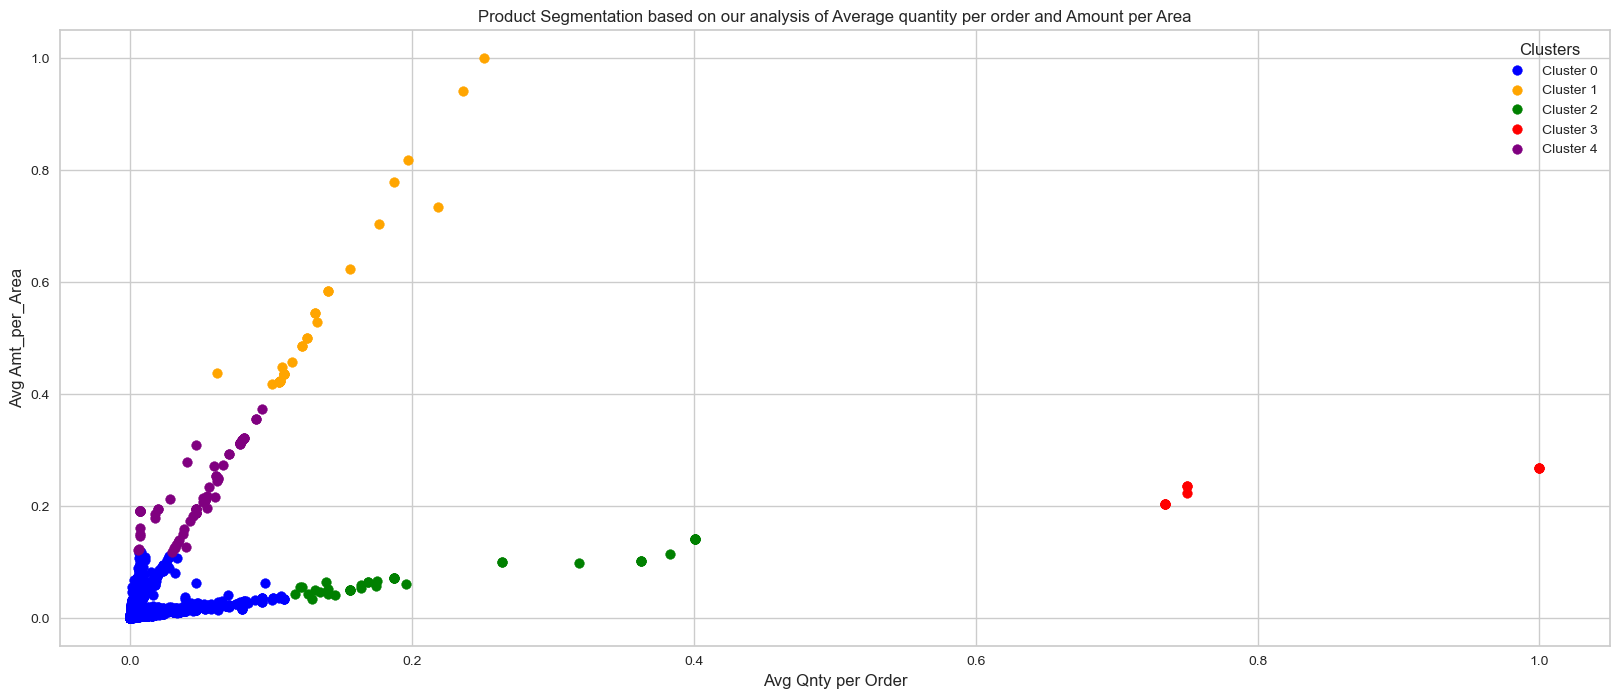

,Item_Id,Total Revenue,Total Quantity,Orders,TotalArea,Amount,Avg Qnty per Order,Average Size,Avg Amt_per_Area,KMeans_cluster_id
0,1,12.00,2,1,6.0,12.00,0.000156,3.0,0.000106,0
1,2,18.00,2,1,9.0,18.00,0.000156,4.5,0.000106,0
2,3,378.00,7,2,108.0,378.00,0.000391,15.4,0.000194,0
3,4,641.25,9,2,142.5,641.25,0.000547,15.8,0.000253,0
4,5,2821.50,22,2,256.5,2821.50,0.001563,11.7,0.000636,0


In [12]:
# Clustering (adjusting the number of clusters based on our analysis of Unique Items and Amount)
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
df_scaled['KMeans_cluster_id'] = kmeans.fit_predict(df_scaled[['Avg Qnty per Order', 'Avg Amt_per_Area']])
 
# Visualization (2D plot for illustration)
plt.figure(figsize=(20, 8))
colors = ['blue', 'orange', 'green', 'red', 'purple']  # Define colors for each cluster
for i in range(num_clusters):
    # Scatter plot for each cluster
                plt.scatter(df_scaled[df_scaled['KMeans_cluster_id'] == i]['Avg Qnty per Order'],df_scaled[df_scaled['KMeans_cluster_id'] == i]['Avg Amt_per_Area'], 
                color=colors[i],label=f'Cluster {i}')
 

plt.ylabel('Avg Amt_per_Area')
plt.xlabel('Avg Qnty per Order')
plt.title('Product Segmentation based on our analysis of Average quantity per order and Amount per Area')
 
# Adding the legend
plt.legend(title='Clusters')
 
plt.show()
 
# Display the DataFrame with clusters
df_scaled.head(5)

In [13]:
cluster_names = {
    0: 'Cheap or Low priced and order in low quantity and could be samples', #because these items are bought in relatively low quantity and lower price
    1: 'Expensive and Fast-moving Item', #because these items are getting bought with high amount in relatively higher quantity
    2: 'Non-Expensive but Fast-moving Item', #because these items are getting bought with high amount in relatively lower quantity
    3: 'Medium Priced Item that go in bulk order',#because these items are bought in resonable price and are sold in bulk quantity, but slow moving
    4: 'Medium priced with moderately paced sales' #because these items are bought in resonable price and the no.of orders are not in bulk 
}

df_scaled['K-Cluster Name'] = df_scaled['KMeans_cluster_id'].map(cluster_names)
df_scaled

,Item_Id,Total Revenue,Total Quantity,Orders,TotalArea,Amount,Avg Qnty per Order,Average Size,Avg Amt_per_Area,KMeans_cluster_id,K-Cluster Name
0,1,12.00,2,1,6.0,12.00,0.000156,3.0,0.000106,0,Cheap or Low priced and order in low quantity ...
1,2,18.00,2,1,9.0,18.00,0.000156,4.5,0.000106,0,Cheap or Low priced and order in low quantity ...
2,3,378.00,7,2,108.0,378.00,0.000391,15.4,0.000194,0,Cheap or Low priced and order in low quantity ...
3,4,641.25,9,2,142.5,641.25,0.000547,15.8,0.000253,0,Cheap or Low priced and order in low quantity ...
4,5,2821.50,22,2,256.5,2821.50,0.001563,11.7,0.000636,0,Cheap or Low priced and order in low quantity ...
...,...,...,...,...,...,...,...,...,...,...,...
5732,46697,663.60,28,1,6.0,663.60,0.004219,0.2,0.006506,0,Cheap or Low priced and order in low quantity ...
5733,46698,888.70,10,1,22.5,888.70,0.001406,2.2,0.002316,0,Cheap or Low priced and order in low quantity ...
5734,46699,4740.00,15,1,80.0,4740.00,0.002188,5.3,0.003477,0,Cheap or Low priced and order in low quantity ...
5735,46700,2986.20,7,1,108.0,2986.20,0.000938,15.4,0.001615,0,Cheap or Low priced and order in low quantity ...


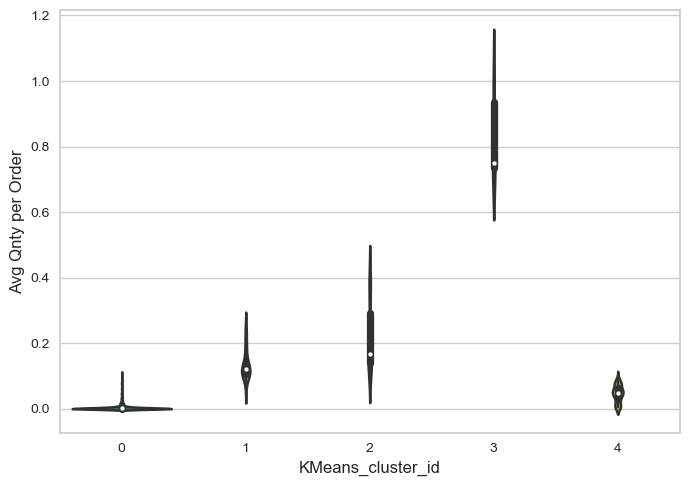

In [14]:
sns.violinplot(data = df_scaled,
              y = 'Avg Qnty per Order',
              x = 'KMeans_cluster_id');

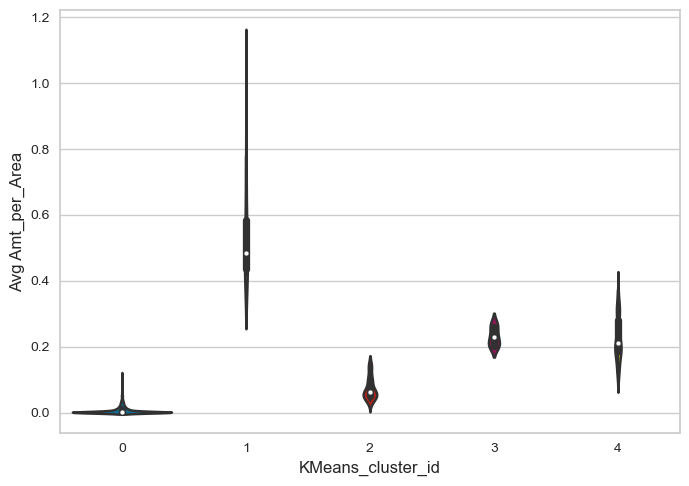

In [15]:
sns.violinplot(data = df_scaled,
              y = 'Avg Amt_per_Area',
              x = 'KMeans_cluster_id');

### Hierarchial Clustering

In [16]:
df_scaled
from sklearn.cluster import AgglomerativeClustering
h_cluster = AgglomerativeClustering(n_clusters = 5,
                                    metric = 'euclidean',
                                    linkage = 'ward',
                                    compute_distances = True)
h_cluster.fit(df_scaled[['Avg Qnty per Order', 'Avg Amt_per_Area']])
df_scaled['hcluster_clusterid'] = h_cluster.labels_
df_scaled.sort_values('hcluster_clusterid')

,Item_Id,Total Revenue,Total Quantity,Orders,TotalArea,Amount,Avg Qnty per Order,Average Size,Avg Amt_per_Area,KMeans_cluster_id,K-Cluster Name,hcluster_clusterid
0,1,12.000,2,1,6.0,12.00,0.000156,3.0,0.000106,0,Cheap or Low priced and order in low quantity ...,0
3746,25028,2504.880,71,4,6.7,2504.88,0.002625,0.1,0.021958,0,Cheap or Low priced and order in low quantity ...,0
3745,25027,6854.400,80,4,16.3,6854.40,0.002969,0.2,0.024740,0,Cheap or Low priced and order in low quantity ...,0
3744,25026,2721.600,60,5,10.8,2721.60,0.001719,0.2,0.014839,0,Cheap or Low priced and order in low quantity ...,0
3743,25025,2445.240,71,9,15.1,2445.24,0.001078,0.2,0.009518,0,Cheap or Low priced and order in low quantity ...,0
...,...,...,...,...,...,...,...,...,...,...,...,...
5438,41566,3433.392,339,1,1.0,3433.39,0.052821,0.0,0.210756,4,Medium priced with moderately paced sales,4
5451,41680,553.250,85,2,0.2,553.25,0.006485,0.0,0.189994,4,Medium priced with moderately paced sales,4
5439,41567,3433.392,339,1,1.0,3433.39,0.052821,0.0,0.210756,4,Medium priced with moderately paced sales,4
4638,32419,2418.000,300,1,0.8,2418.00,0.046726,0.0,0.186559,4,Medium priced with moderately paced sales,4


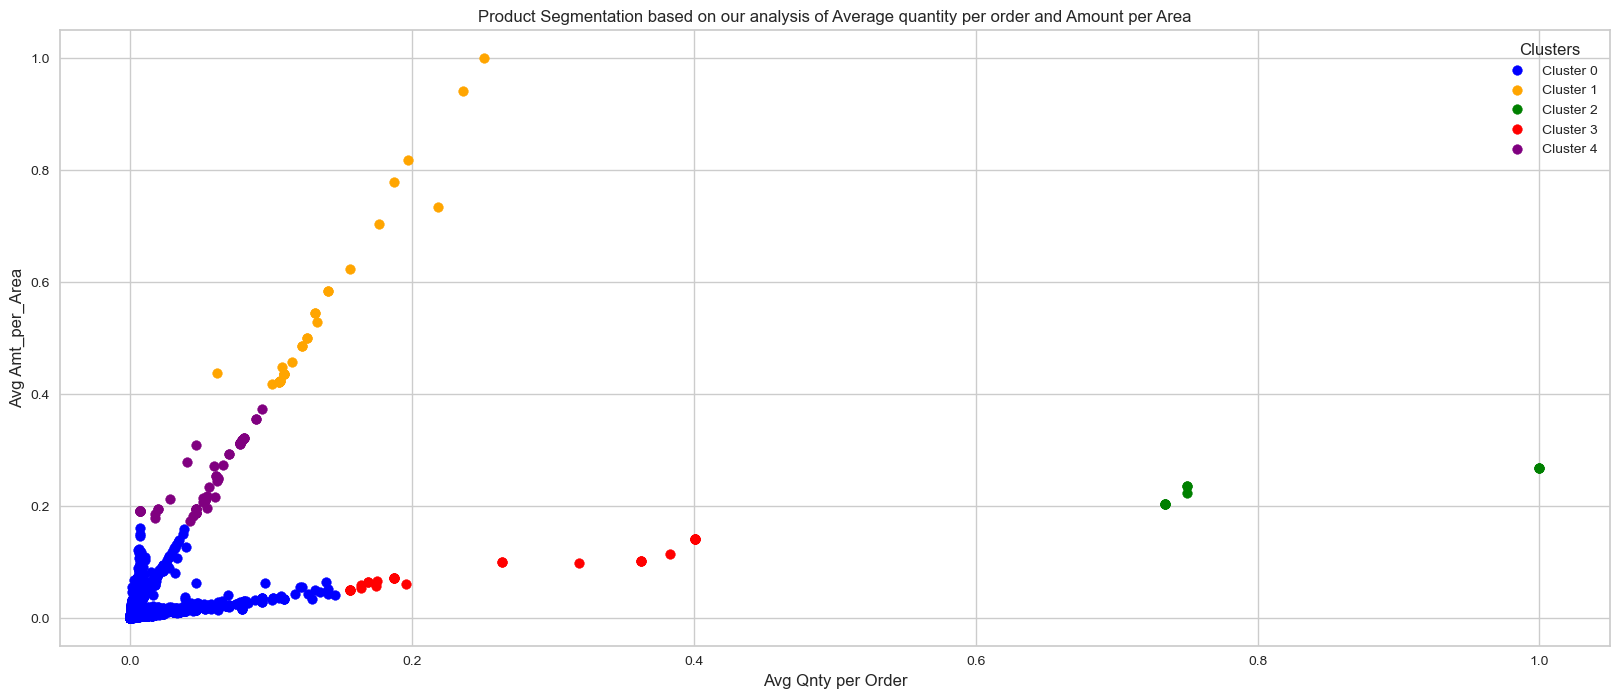

,Item_Id,Total Revenue,Total Quantity,Orders,TotalArea,Amount,Avg Qnty per Order,Average Size,Avg Amt_per_Area,KMeans_cluster_id,K-Cluster Name,hcluster_clusterid,Hiearchial-Cluster Name
0,1,12.00,2,1,6.0,12.00,0.000156,3.0,0.000106,0,Cheap or Low priced and order in low quantity ...,0,Cheap or Low priced and order in low quantity ...
1,2,18.00,2,1,9.0,18.00,0.000156,4.5,0.000106,0,Cheap or Low priced and order in low quantity ...,0,Cheap or Low priced and order in low quantity ...
2,3,378.00,7,2,108.0,378.00,0.000391,15.4,0.000194,0,Cheap or Low priced and order in low quantity ...,0,Cheap or Low priced and order in low quantity ...
3,4,641.25,9,2,142.5,641.25,0.000547,15.8,0.000253,0,Cheap or Low priced and order in low quantity ...,0,Cheap or Low priced and order in low quantity ...
4,5,2821.50,22,2,256.5,2821.50,0.001563,11.7,0.000636,0,Cheap or Low priced and order in low quantity ...,0,Cheap or Low priced and order in low quantity ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5732,46697,663.60,28,1,6.0,663.60,0.004219,0.2,0.006506,0,Cheap or Low priced and order in low quantity ...,0,Cheap or Low priced and order in low quantity ...
5733,46698,888.70,10,1,22.5,888.70,0.001406,2.2,0.002316,0,Cheap or Low priced and order in low quantity ...,0,Cheap or Low priced and order in low quantity ...
5734,46699,4740.00,15,1,80.0,4740.00,0.002188,5.3,0.003477,0,Cheap or Low priced and order in low quantity ...,0,Cheap or Low priced and order in low quantity ...
5735,46700,2986.20,7,1,108.0,2986.20,0.000938,15.4,0.001615,0,Cheap or Low priced and order in low quantity ...,0,Cheap or Low priced and order in low quantity ...


In [17]:
plt.figure(figsize=(20, 8))
colors = ['blue', 'orange', 'green', 'red', 'purple']  # Define colors for each cluster
for i in range(num_clusters):
    # Scatter plot for each cluster
                plt.scatter(df_scaled[df_scaled['hcluster_clusterid'] == i]['Avg Qnty per Order'],df_scaled[df_scaled['hcluster_clusterid'] == i]['Avg Amt_per_Area'], 
                color=colors[i],label=f'Cluster {i}')
 

plt.ylabel('Avg Amt_per_Area')
plt.xlabel('Avg Qnty per Order')
plt.title('Product Segmentation based on our analysis of Average quantity per order and Amount per Area')
 
# Adding the legend
plt.legend(title='Clusters')
 
plt.show()
 
# Display the DataFrame with clusters
df_scaled.head(5)
cluster_names = {
    0: 'Cheap or Low priced and order in low quantity and could be samples', #because these items are bought in relatively low quantity and lower price
    1: 'Expensive and Fast-moving Item', #because these items are getting bought with high amount in relatively higher quantity
    2: 'Non-Expensive but Fast-moving Item', #because these items are getting bought with high amount in relatively lower quantity
    3: 'Medium Priced Item that go in bulk order',#because these items are bought in resonable price and are sold in bulk quantity, but slow moving
    4: 'Medium priced with moderately paced sales' #because these items are bought in resonable price and the no.of orders are not in bulk 
}

df_scaled['Hiearchial-Cluster Name'] = df_scaled['hcluster_clusterid'].map(cluster_names)
df_scaled

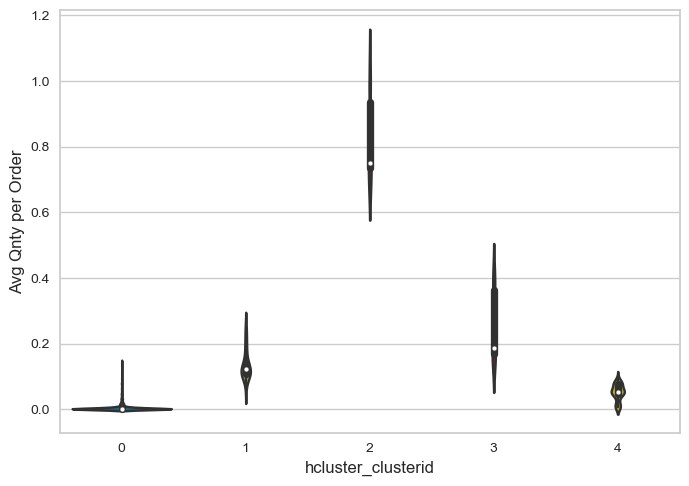

In [18]:
sns.violinplot(data = df_scaled,
              y = 'Avg Qnty per Order',
              x = 'hcluster_clusterid');

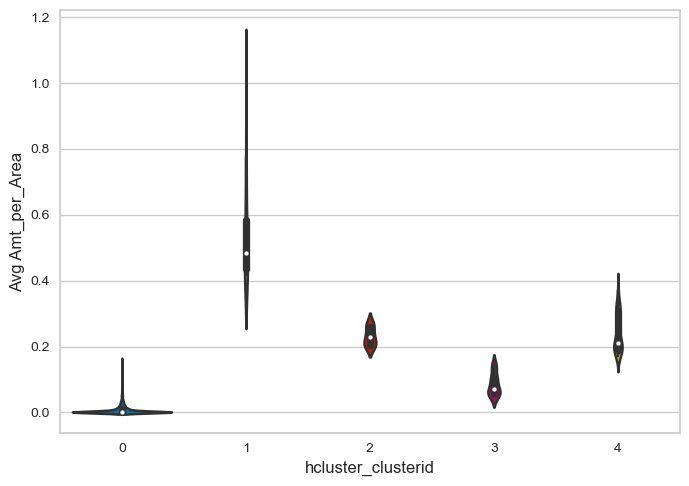

In [19]:
sns.violinplot(data = df_scaled,
              y = 'Avg Amt_per_Area',
              x = 'hcluster_clusterid');

### HDBSCAN Clustering

In [20]:
from sklearn.cluster import HDBSCAN
hdbscan = HDBSCAN(min_cluster_size=2)
hdbscan.fit(df_scaled[['Avg Qnty per Order', 'Avg Amt_per_Area']])

HDBSCAN(min_cluster_size=2)

In [21]:
hdbscan.labels_
df_scaled['hdbscan_clusterid'] = hdbscan.labels_
df_scaled

,Item_Id,Total Revenue,Total Quantity,Orders,TotalArea,Amount,Avg Qnty per Order,Average Size,Avg Amt_per_Area,KMeans_cluster_id,K-Cluster Name,hcluster_clusterid,Hiearchial-Cluster Name,hdbscan_clusterid
0,1,12.00,2,1,6.0,12.00,0.000156,3.0,0.000106,0,Cheap or Low priced and order in low quantity ...,0,Cheap or Low priced and order in low quantity ...,978
1,2,18.00,2,1,9.0,18.00,0.000156,4.5,0.000106,0,Cheap or Low priced and order in low quantity ...,0,Cheap or Low priced and order in low quantity ...,978
2,3,378.00,7,2,108.0,378.00,0.000391,15.4,0.000194,0,Cheap or Low priced and order in low quantity ...,0,Cheap or Low priced and order in low quantity ...,886
3,4,641.25,9,2,142.5,641.25,0.000547,15.8,0.000253,0,Cheap or Low priced and order in low quantity ...,0,Cheap or Low priced and order in low quantity ...,909
4,5,2821.50,22,2,256.5,2821.50,0.001563,11.7,0.000636,0,Cheap or Low priced and order in low quantity ...,0,Cheap or Low priced and order in low quantity ...,763
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5732,46697,663.60,28,1,6.0,663.60,0.004219,0.2,0.006506,0,Cheap or Low priced and order in low quantity ...,0,Cheap or Low priced and order in low quantity ...,404
5733,46698,888.70,10,1,22.5,888.70,0.001406,2.2,0.002316,0,Cheap or Low priced and order in low quantity ...,0,Cheap or Low priced and order in low quantity ...,708
5734,46699,4740.00,15,1,80.0,4740.00,0.002188,5.3,0.003477,0,Cheap or Low priced and order in low quantity ...,0,Cheap or Low priced and order in low quantity ...,613
5735,46700,2986.20,7,1,108.0,2986.20,0.000938,15.4,0.001615,0,Cheap or Low priced and order in low quantity ...,0,Cheap or Low priced and order in low quantity ...,799


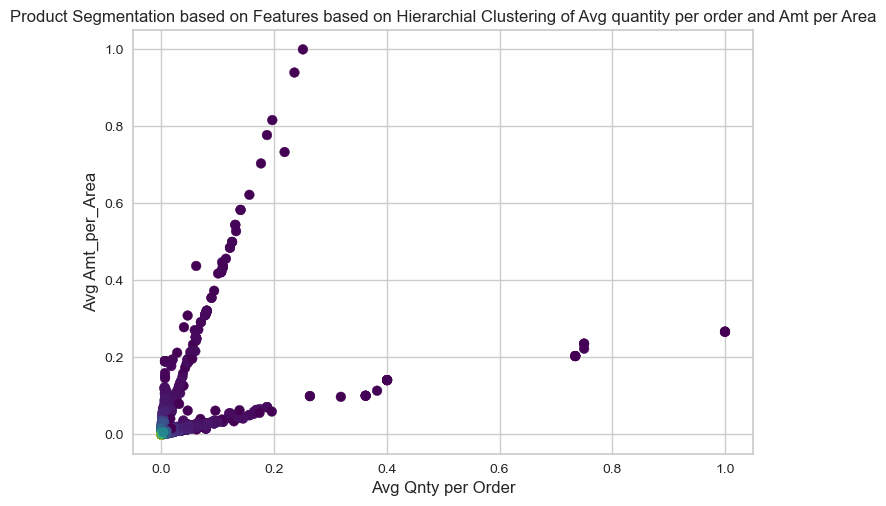

<Figure size 700x400 with 0 Axes>

In [22]:
# Visualize the HDBSCAN clusters

plt.scatter(df_scaled['Avg Qnty per Order'], df_scaled['Avg Amt_per_Area'], 
            c=df_scaled['hdbscan_clusterid'], cmap='viridis')
 
plt.title('Product Segmentation based on Features based on Hierarchial Clustering of Avg quantity per order and Amt per Area')
plt.xlabel('Avg Qnty per Order')
plt.ylabel('Avg Amt_per_Area')
plt.figure(figsize=(7, 4))
plt.show()

In [23]:
df_scaled

,Item_Id,Total Revenue,Total Quantity,Orders,TotalArea,Amount,Avg Qnty per Order,Average Size,Avg Amt_per_Area,KMeans_cluster_id,K-Cluster Name,hcluster_clusterid,Hiearchial-Cluster Name,hdbscan_clusterid
0,1,12.00,2,1,6.0,12.00,0.000156,3.0,0.000106,0,Cheap or Low priced and order in low quantity ...,0,Cheap or Low priced and order in low quantity ...,978
1,2,18.00,2,1,9.0,18.00,0.000156,4.5,0.000106,0,Cheap or Low priced and order in low quantity ...,0,Cheap or Low priced and order in low quantity ...,978
2,3,378.00,7,2,108.0,378.00,0.000391,15.4,0.000194,0,Cheap or Low priced and order in low quantity ...,0,Cheap or Low priced and order in low quantity ...,886
3,4,641.25,9,2,142.5,641.25,0.000547,15.8,0.000253,0,Cheap or Low priced and order in low quantity ...,0,Cheap or Low priced and order in low quantity ...,909
4,5,2821.50,22,2,256.5,2821.50,0.001563,11.7,0.000636,0,Cheap or Low priced and order in low quantity ...,0,Cheap or Low priced and order in low quantity ...,763
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5732,46697,663.60,28,1,6.0,663.60,0.004219,0.2,0.006506,0,Cheap or Low priced and order in low quantity ...,0,Cheap or Low priced and order in low quantity ...,404
5733,46698,888.70,10,1,22.5,888.70,0.001406,2.2,0.002316,0,Cheap or Low priced and order in low quantity ...,0,Cheap or Low priced and order in low quantity ...,708
5734,46699,4740.00,15,1,80.0,4740.00,0.002188,5.3,0.003477,0,Cheap or Low priced and order in low quantity ...,0,Cheap or Low priced and order in low quantity ...,613
5735,46700,2986.20,7,1,108.0,2986.20,0.000938,15.4,0.001615,0,Cheap or Low priced and order in low quantity ...,0,Cheap or Low priced and order in low quantity ...,799


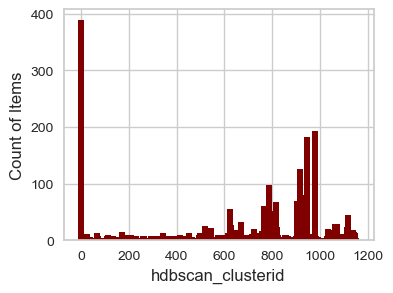

In [51]:
fig = plt.figure(figsize = (4, 3))
df_bar = df_scaled.groupby('hdbscan_clusterid').agg({'Item_Id':'count'}).reset_index()

#creating the bar plot
plt.bar(df_bar['hdbscan_clusterid'], df_bar['Item_Id'], color ='maroon', 
        width = 25)
 
plt.xlabel("hdbscan_clusterid")
plt.ylabel("Count of Items")
plt.show()

### Product Cluster Based on Purchase Patterns. 


##### Cluster the products based on how they are being bought together in orders. Also have to choose the right metrics to cluster the products. 

In [24]:
order_groups = data.groupby('OrderiD')['Item_Id'].unique().reset_index()
order_groups

,OrderiD,Item_Id
0,1,"[5, 26, 17, 496, 30, 34, 19, 4, 29, 28, 52, 24..."
1,2,"[784, 563, 779, 791, 564, 780, 785, 571, 783, ..."
2,3,"[1167, 2674]"
3,4,"[5, 34, 1763, 50, 4, 3, 48, 1764, 42, 40, 1754..."
4,5,"[1771, 1769, 1768, 773, 1767, 772, 1770, 774]"
...,...,...
2225,7527,"[3992, 3987]"
2226,7528,[3988]
2227,7529,"[46667, 46671, 46694, 46661, 46695, 46677, 466..."
2228,7532,"[36818, 34967, 36814, 36813, 36816, 36815, 368..."


#### Clustering

In [25]:
one_hot_encoded_data_1 = pd.get_dummies(data, columns = ['OrderiD'])
one_hot_encoded_data_1.drop(
    columns=['CustomerCode','CountryName','customer_country','QtyRequired',
             'TotalArea','Amount','ITEM_NAME','DesignName','QualityName',
            'ColorName','ShapeName','Amt_per_Area','Amt_per_Qnty'], inplace=True)
one_hot_encoded_data_1.set_index("Item_Id", inplace = True)
one_hot_encoded_data_1

,OrderiD_1,OrderiD_2,OrderiD_3,OrderiD_4,OrderiD_5,OrderiD_6,OrderiD_7,OrderiD_8,OrderiD_9,OrderiD_10,...,OrderiD_7522,OrderiD_7523,OrderiD_7524,OrderiD_7525,OrderiD_7526,OrderiD_7527,OrderiD_7528,OrderiD_7529,OrderiD_7532,OrderiD_7548
Item_Id,,,,,,,,,,,,,,,,,,,,,
5,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
26,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
496,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
30,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36816,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
36815,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
36817,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [26]:
from scipy.spatial.distance import jaccard
from sklearn.metrics.pairwise import pairwise_distances 
jaccard_similarity = 1 - pairwise_distances(one_hot_encoded_data_1.values, metric="jaccard")

In [27]:
print(jaccard_similarity)
df=pd.DataFrame(jaccard_similarity, index = one_hot_encoded_data_1.index, columns = one_hot_encoded_data_1.index )
df

[[1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 1. 0.]
 [0. 0. 0. ... 1. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


Item_Id,5,26,17,496,30,34,19,4,29,28,...,46679,36818,34967,36814,36813,36816,36815,36817,36812,15721
Item_Id,,,,,,,,,,,,,,,,,,,,,
5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
496,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
30,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36816,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
36815,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
36817,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0


<Axes: ylabel='Item_Id'>

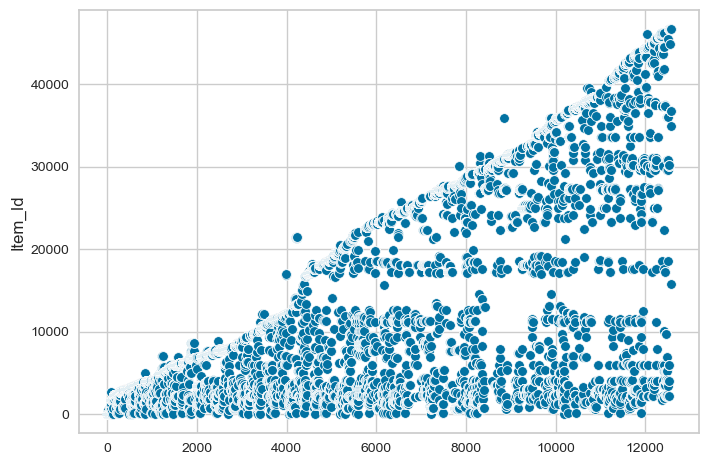

In [28]:
sns.scatterplot(data = df.index)

In [29]:
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
df['Cluster'] = kmeans.fit_predict(df[:])

In [31]:
print("Length of the dataframe of Cluster 0 is : ",len(df[df['Cluster'] == 0]))
df[df['Cluster'] == 0].head(10)

Length of the dataframe of Cluster 0 is :  12287


Item_Id,5,26,17,496,30,34,19,4,29,28,...,36818,34967,36814,36813,36816,36815,36817,36812,15721,Cluster
Item_Id,,,,,,,,,,,,,,,,,,,,,
5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
26,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
17,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
496,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
30,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
34,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
19,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
29,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [39]:
print("Length of the dataframe of Cluster 1 is : ",len(df[df['Cluster'] == 1]))
df[df['Cluster'] == 1].head(10)

Length of the dataframe of Cluster 1 is :  114


Item_Id,5,26,17,496,30,34,19,4,29,28,...,36818,34967,36814,36813,36816,36815,36817,36812,15721,Cluster
Item_Id,,,,,,,,,,,,,,,,,,,,,
1409,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1397,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1412,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
24242,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2305,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
19941,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
24240,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1410,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1210,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [34]:
print("Length of the dataframe of Cluster 2 is : ",len(df[df['Cluster'] == 2]))
df[df['Cluster'] == 2].head(10)

Length of the dataframe of Cluster 2 is :  48


Item_Id,5,26,17,496,30,34,19,4,29,28,...,36818,34967,36814,36813,36816,36815,36817,36812,15721,Cluster
Item_Id,,,,,,,,,,,,,,,,,,,,,
12606,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
2488,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
1410,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
1412,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
1210,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
11537,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
1409,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
11524,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
11224,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2


In [37]:
print("Length of the dataframe of Cluster 3 is : ",len(df[df['Cluster'] == 3]))
df[df['Cluster'] == 3].head(10)

Length of the dataframe of Cluster 3 is :  59


Item_Id,5,26,17,496,30,34,19,4,29,28,...,36818,34967,36814,36813,36816,36815,36817,36812,15721,Cluster
Item_Id,,,,,,,,,,,,,,,,,,,,,
1150,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
4969,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
5007,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
88,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
1135,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
1155,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
1283,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
5002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
89,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3


In [38]:
print("Length of the dataframe of Cluster 4 is : ",len(df[df['Cluster'] == 4]))
df[df['Cluster'] == 4].head(10)

Length of the dataframe of Cluster 4 is :  69


Item_Id,5,26,17,496,30,34,19,4,29,28,...,36818,34967,36814,36813,36816,36815,36817,36812,15721,Cluster
Item_Id,,,,,,,,,,,,,,,,,,,,,
10503,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
10468,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
10663,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
10504,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
10469,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
12122,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
10455,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
10462,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
10465,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
